This project is based on the article provided by Diego Gomez Mosquera on [medium.com](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f#Training%20a%20GAN)

In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader  # Dataset management. It helps us create mini-batches to train and ..
import torchvision.datasets as datasets  # Datasets such as MNIST
import torchvision.transforms as transforms  # transformations that we can do on our datasets 
from util import Logger
import numpy as np
import matplotlib.pyplot as plt

## Hyperparameters

In [16]:
discriminator_input_size = 784  # 28*28 pixels
generator_input_size = 100
discriminator_output_size = 1  # a probability in range [0-1]
learning_rate = 0.0002
batch_size = 100
num_epochs = 200

## Set device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reading From Dataset

In [4]:
# Train data
train_dataset = datasets.MNIST(root='dataset/',
                train=True,
                transform=transforms.ToTensor(), # The data is numpy and we want it to be transformed to PyTorch Tensors
                download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\Asus\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# data size:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Creating Discriminator & Generator

In [6]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()

        self.hidden1 = nn.Sequential( 
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),    # the slope for negative X values in ReLU function
            nn.Dropout(0.3)    # the probability of dropping out neurons
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.output = nn.Sequential(
            torch.nn.Linear(256, output_size),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.output(x)
        return x
    
discriminator = Discriminator(input_size=discriminator_input_size, output_size=discriminator_output_size).to(device=device)

In [7]:
class Generator(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.output = nn.Sequential(
            nn.Linear(1024, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.output(x)
        return x
generator = Generator(input_size=generator_input_size, output_size=discriminator_input_size).to(device=device)

## Loss and Optimizier

In [8]:
loss = nn.BCELoss()

In [9]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

## Train functions

In [10]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    number_of_data = real_data.size(0)
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(number_of_data) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(number_of_data))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [12]:
def train_generator(optimizer, fake_data):
    number_of_data = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)

    # Calculate error and backpropagate
    error = loss(prediction, ones_target(number_of_data))
    error.backward()

    # Update weights with gradients
    optimizer.step()

    return error

## Creating test noise for the generator

In [13]:
def create_noise(size):
    return torch.randn(size, 100).to(device=device)

In [14]:
num_test_samples = 16
test_noise = Variable(create_noise(num_test_samples))

## Train Network

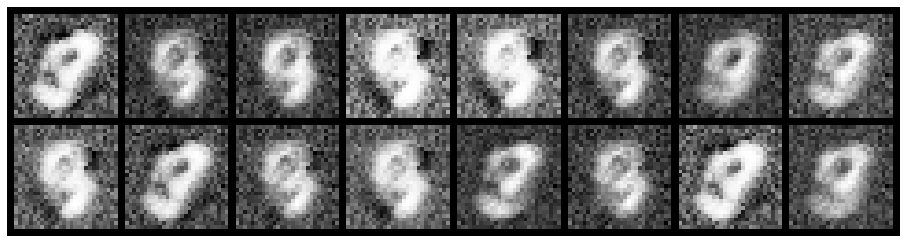

Epoch: [0/200], Batch Num: [0/100]
Discriminator Loss: 1.2930, Generator Loss: 2.1477
D(x): 0.6132, D(G(z)): 0.2984


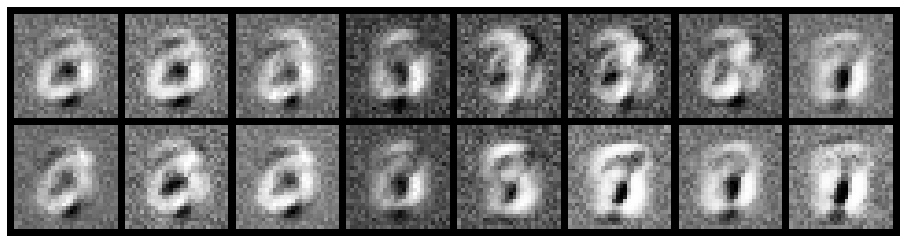

Epoch: [5/200], Batch Num: [0/100]
Discriminator Loss: 0.9270, Generator Loss: 1.6334
D(x): 0.6765, D(G(z)): 0.2693


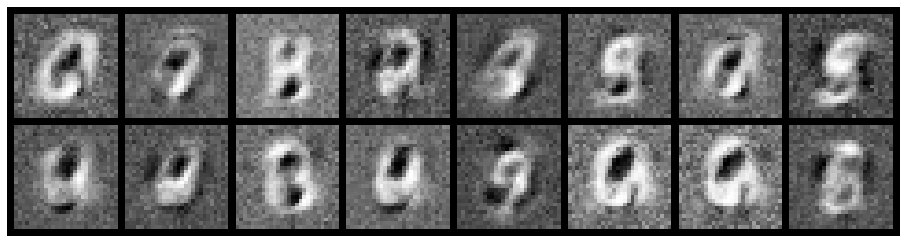

Epoch: [10/200], Batch Num: [0/100]
Discriminator Loss: 0.4872, Generator Loss: 1.9152
D(x): 0.9101, D(G(z)): 0.2576


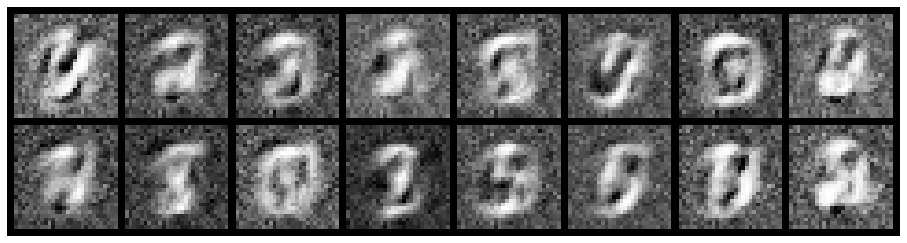

Epoch: [15/200], Batch Num: [0/100]
Discriminator Loss: 0.6893, Generator Loss: 2.3687
D(x): 0.8226, D(G(z)): 0.2233


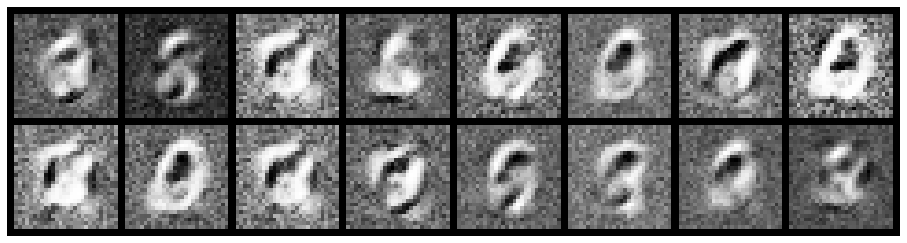

Epoch: [20/200], Batch Num: [0/100]
Discriminator Loss: 0.5117, Generator Loss: 2.5632
D(x): 0.8304, D(G(z)): 0.1626


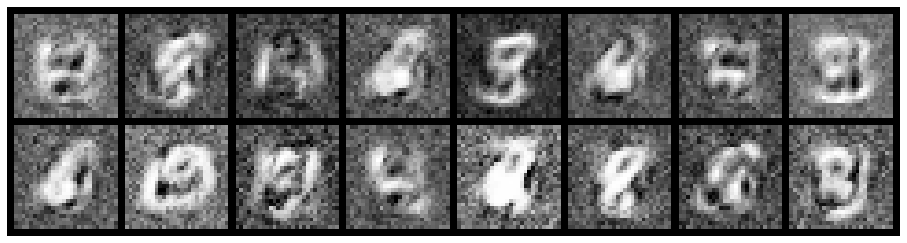

Epoch: [25/200], Batch Num: [0/100]
Discriminator Loss: 0.7486, Generator Loss: 1.9109
D(x): 0.7857, D(G(z)): 0.2322


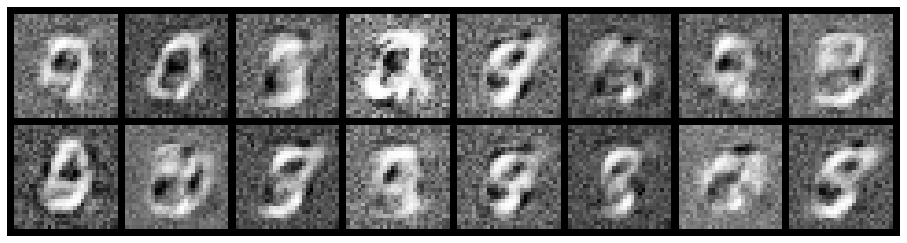

Epoch: [30/200], Batch Num: [0/100]
Discriminator Loss: 0.7708, Generator Loss: 2.6746
D(x): 0.7972, D(G(z)): 0.1841


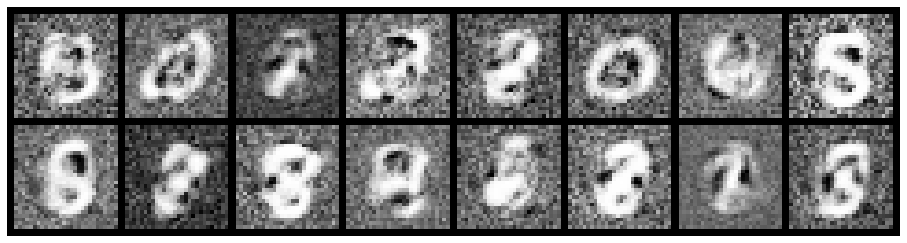

Epoch: [35/200], Batch Num: [0/100]
Discriminator Loss: 0.5831, Generator Loss: 2.2853
D(x): 0.8307, D(G(z)): 0.1780


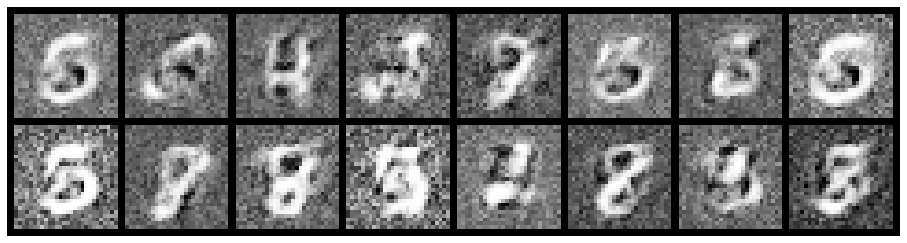

Epoch: [40/200], Batch Num: [0/100]
Discriminator Loss: 0.4188, Generator Loss: 2.7725
D(x): 0.8463, D(G(z)): 0.1388


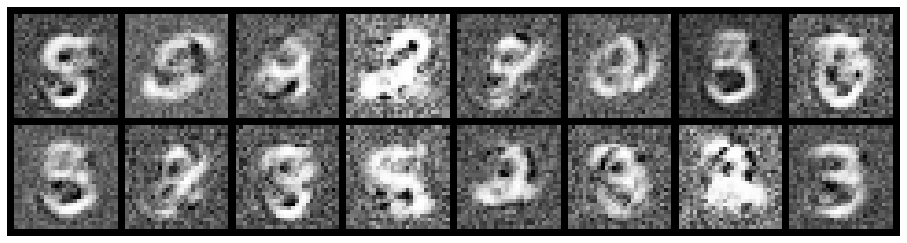

Epoch: [45/200], Batch Num: [0/100]
Discriminator Loss: 0.3860, Generator Loss: 2.8872
D(x): 0.8780, D(G(z)): 0.1196


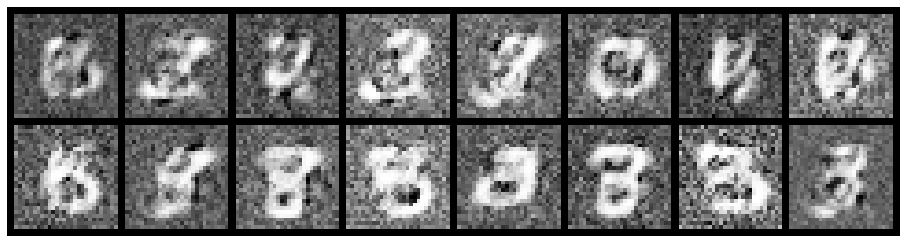

Epoch: [50/200], Batch Num: [0/100]
Discriminator Loss: 0.4610, Generator Loss: 2.9671
D(x): 0.8480, D(G(z)): 0.1202


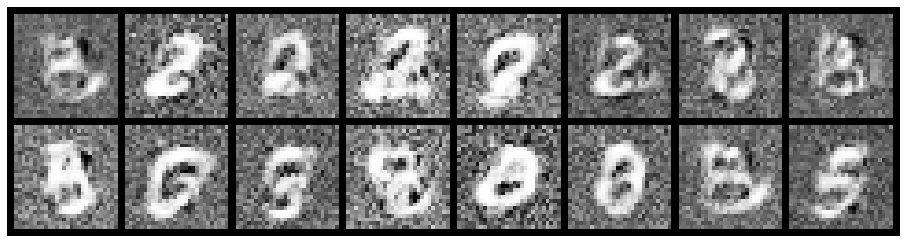

Epoch: [55/200], Batch Num: [0/100]
Discriminator Loss: 0.3081, Generator Loss: 4.9277
D(x): 0.9104, D(G(z)): 0.0733


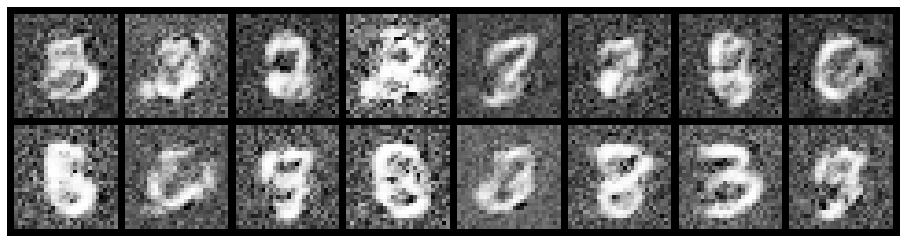

Epoch: [60/200], Batch Num: [0/100]
Discriminator Loss: 0.2870, Generator Loss: 4.0349
D(x): 0.9059, D(G(z)): 0.0593


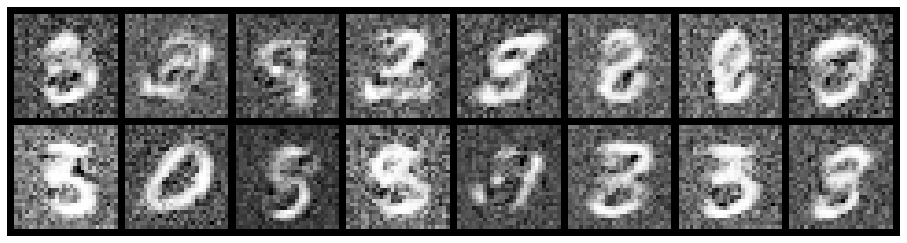

Epoch: [65/200], Batch Num: [0/100]
Discriminator Loss: 0.3095, Generator Loss: 3.7849
D(x): 0.8854, D(G(z)): 0.0774


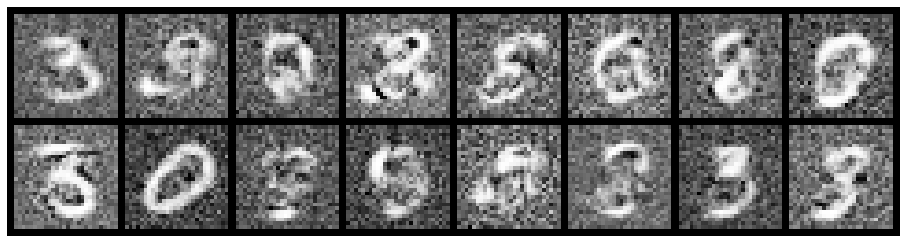

Epoch: [70/200], Batch Num: [0/100]
Discriminator Loss: 0.2718, Generator Loss: 3.4954
D(x): 0.9405, D(G(z)): 0.1148


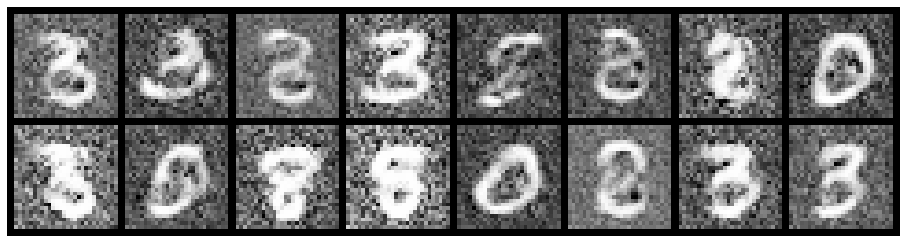

Epoch: [75/200], Batch Num: [0/100]
Discriminator Loss: 0.2740, Generator Loss: 3.9783
D(x): 0.9266, D(G(z)): 0.1006


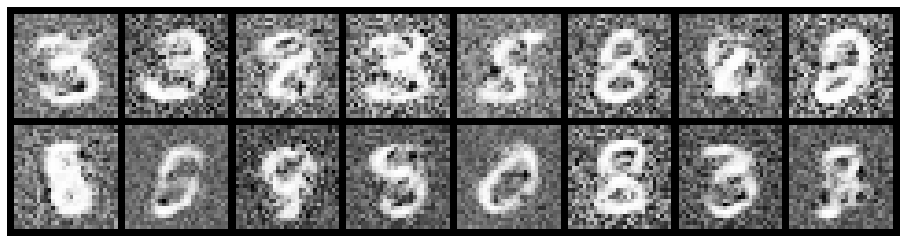

Epoch: [80/200], Batch Num: [0/100]
Discriminator Loss: 0.2410, Generator Loss: 3.9818
D(x): 0.9049, D(G(z)): 0.0427


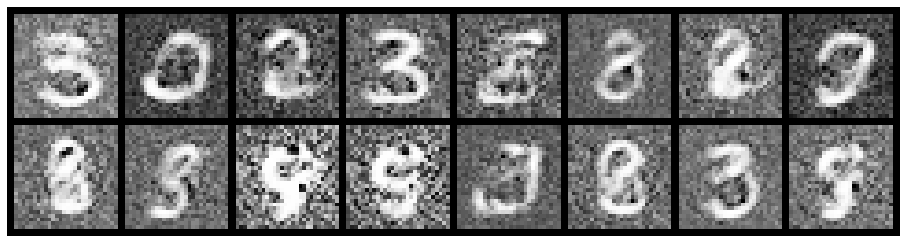

Epoch: [85/200], Batch Num: [0/100]
Discriminator Loss: 0.3084, Generator Loss: 3.6487
D(x): 0.9315, D(G(z)): 0.0912


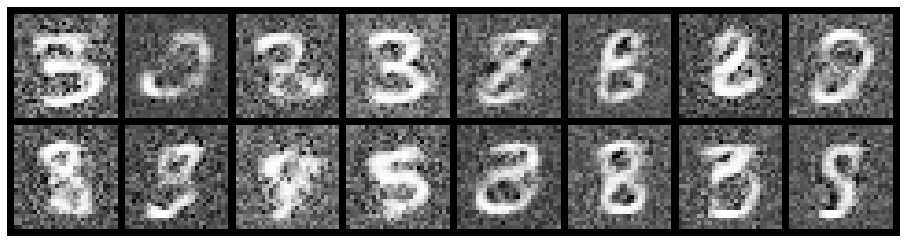

Epoch: [90/200], Batch Num: [0/100]
Discriminator Loss: 0.1742, Generator Loss: 4.0226
D(x): 0.9470, D(G(z)): 0.0672


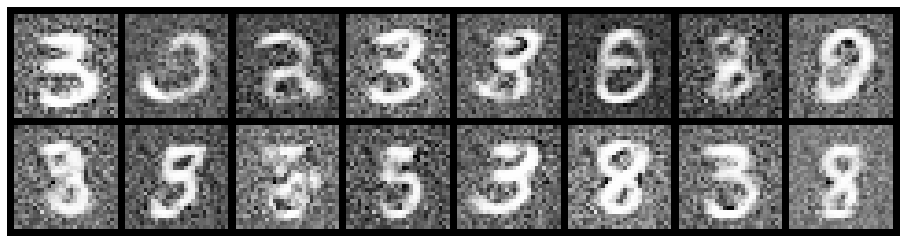

Epoch: [95/200], Batch Num: [0/100]
Discriminator Loss: 0.2019, Generator Loss: 3.8084
D(x): 0.9458, D(G(z)): 0.0782


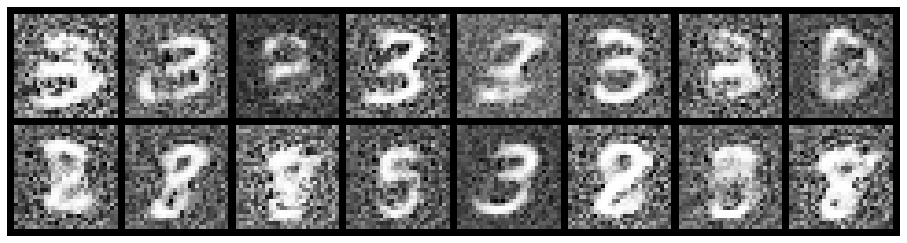

Epoch: [100/200], Batch Num: [0/100]
Discriminator Loss: 0.2451, Generator Loss: 4.0930
D(x): 0.9257, D(G(z)): 0.0853


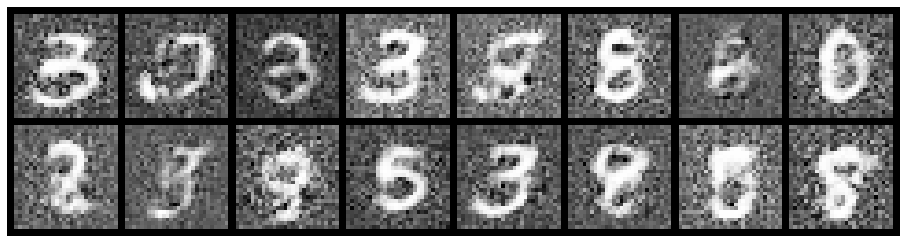

Epoch: [105/200], Batch Num: [0/100]
Discriminator Loss: 0.1347, Generator Loss: 3.8791
D(x): 0.9400, D(G(z)): 0.0470


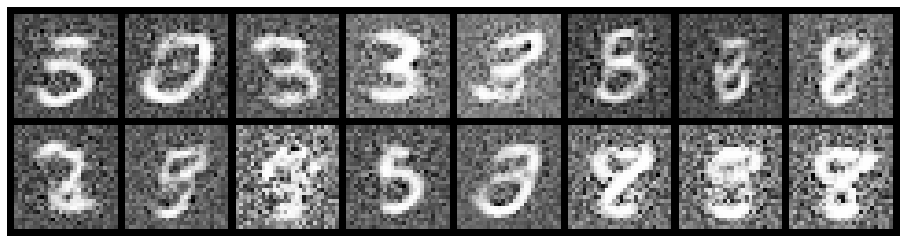

Epoch: [110/200], Batch Num: [0/100]
Discriminator Loss: 0.2886, Generator Loss: 3.9791
D(x): 0.9325, D(G(z)): 0.1216


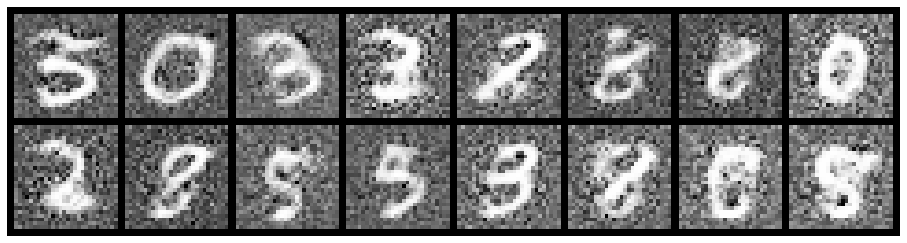

Epoch: [115/200], Batch Num: [0/100]
Discriminator Loss: 0.4007, Generator Loss: 3.5985
D(x): 0.9019, D(G(z)): 0.1105


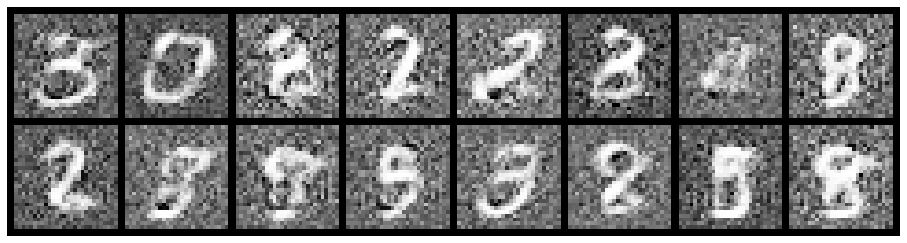

Epoch: [120/200], Batch Num: [0/100]
Discriminator Loss: 0.3491, Generator Loss: 4.3529
D(x): 0.9058, D(G(z)): 0.0892


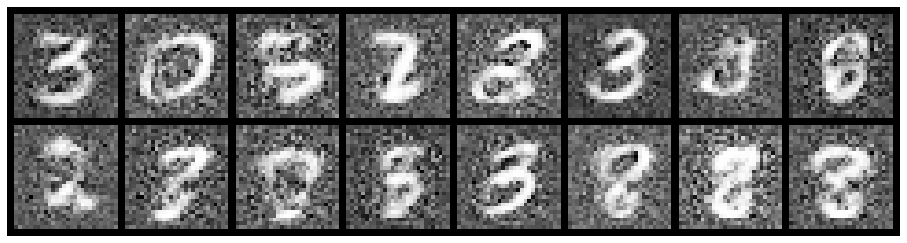

Epoch: [125/200], Batch Num: [0/100]
Discriminator Loss: 0.2174, Generator Loss: 4.1582
D(x): 0.9233, D(G(z)): 0.0545


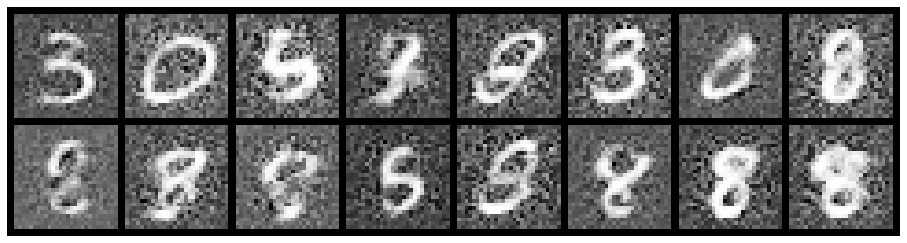

Epoch: [130/200], Batch Num: [0/100]
Discriminator Loss: 0.1462, Generator Loss: 3.8288
D(x): 0.9473, D(G(z)): 0.0607


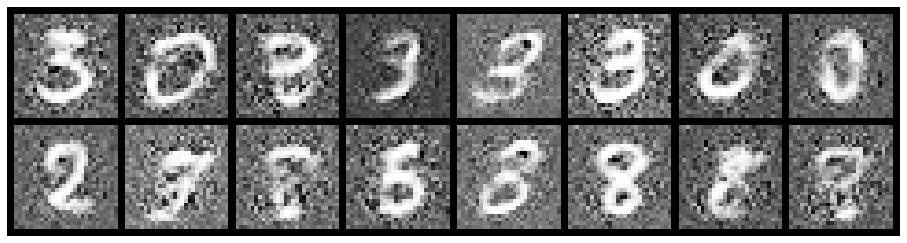

Epoch: [135/200], Batch Num: [0/100]
Discriminator Loss: 0.2067, Generator Loss: 4.1179
D(x): 0.9536, D(G(z)): 0.0672


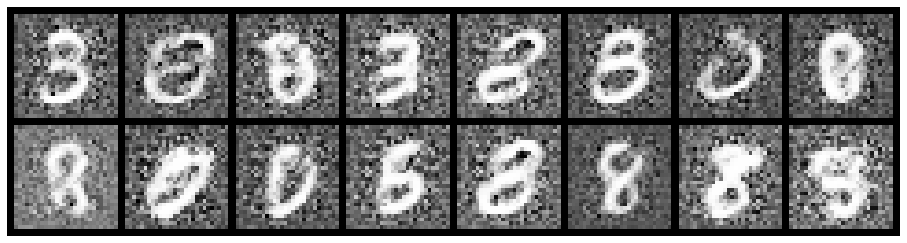

Epoch: [140/200], Batch Num: [0/100]
Discriminator Loss: 0.2761, Generator Loss: 4.0661
D(x): 0.9355, D(G(z)): 0.0900


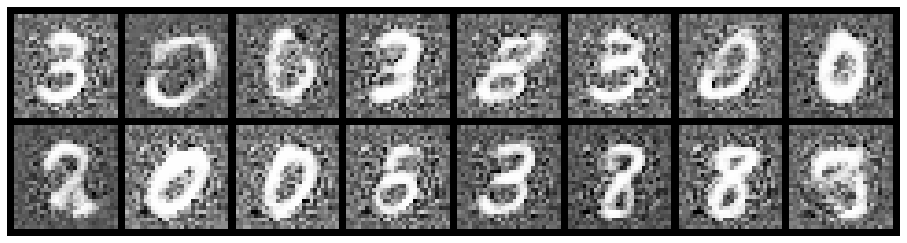

Epoch: [145/200], Batch Num: [0/100]
Discriminator Loss: 0.3118, Generator Loss: 4.8227
D(x): 0.9140, D(G(z)): 0.0721


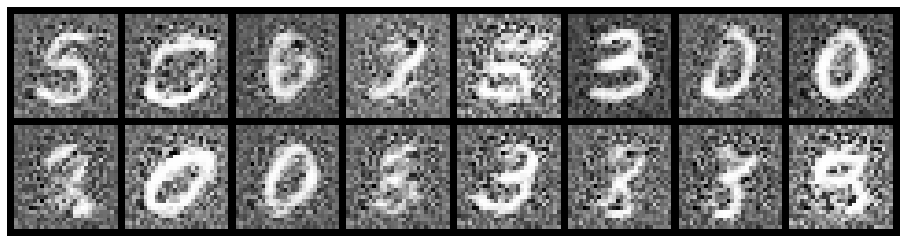

Epoch: [150/200], Batch Num: [0/100]
Discriminator Loss: 0.2218, Generator Loss: 4.2091
D(x): 0.9248, D(G(z)): 0.0592


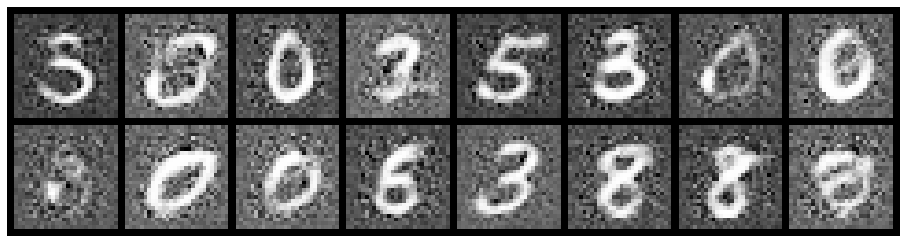

Epoch: [155/200], Batch Num: [0/100]
Discriminator Loss: 0.2800, Generator Loss: 4.2419
D(x): 0.9238, D(G(z)): 0.0696


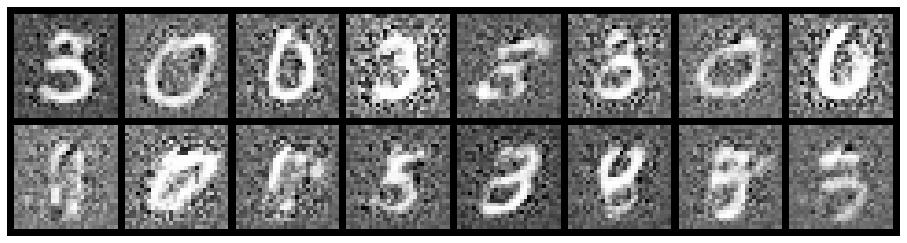

Epoch: [160/200], Batch Num: [0/100]
Discriminator Loss: 0.5020, Generator Loss: 4.4249
D(x): 0.9385, D(G(z)): 0.1671


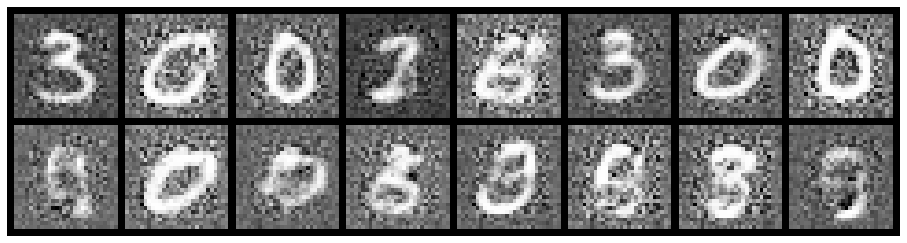

Epoch: [165/200], Batch Num: [0/100]
Discriminator Loss: 0.2754, Generator Loss: 3.5124
D(x): 0.9246, D(G(z)): 0.0849


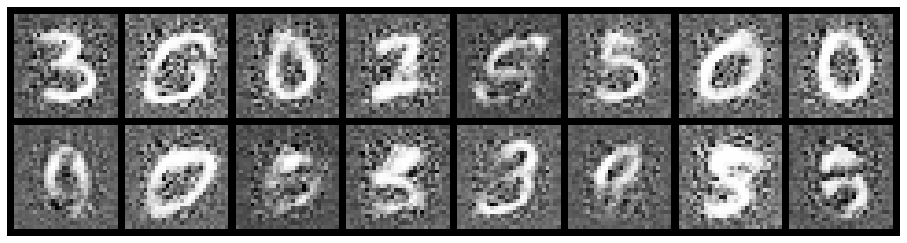

Epoch: [170/200], Batch Num: [0/100]
Discriminator Loss: 0.2154, Generator Loss: 3.5171
D(x): 0.9361, D(G(z)): 0.0860


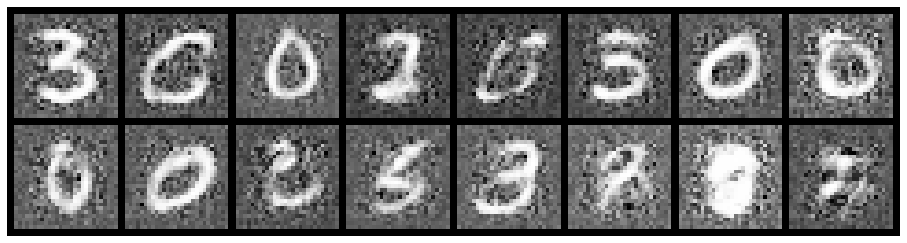

Epoch: [175/200], Batch Num: [0/100]
Discriminator Loss: 0.2064, Generator Loss: 4.0303
D(x): 0.9307, D(G(z)): 0.0609


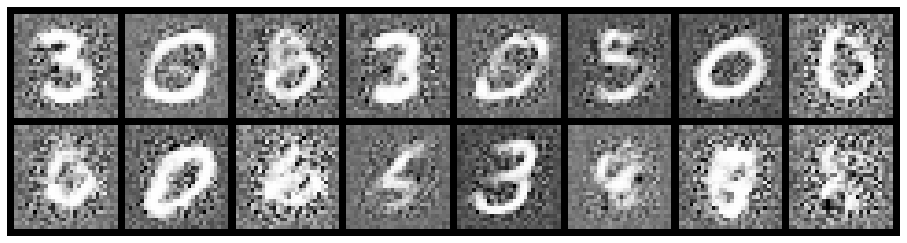

Epoch: [180/200], Batch Num: [0/100]
Discriminator Loss: 0.4594, Generator Loss: 4.6907
D(x): 0.8604, D(G(z)): 0.0603


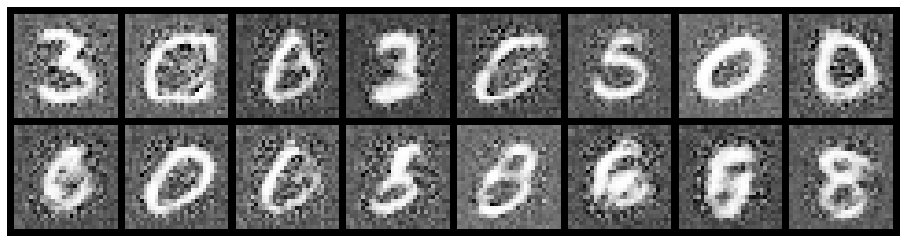

Epoch: [185/200], Batch Num: [0/100]
Discriminator Loss: 0.3732, Generator Loss: 4.0954
D(x): 0.8764, D(G(z)): 0.0712


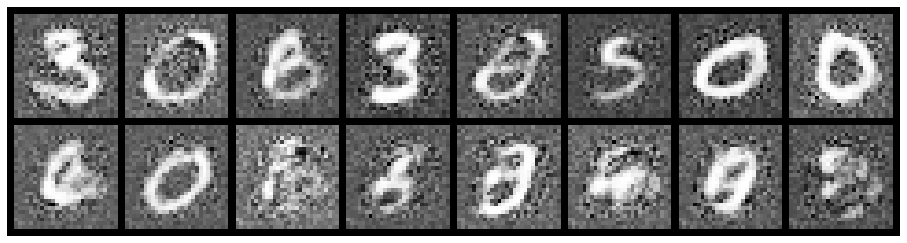

Epoch: [190/200], Batch Num: [0/100]
Discriminator Loss: 0.2946, Generator Loss: 3.5576
D(x): 0.9189, D(G(z)): 0.0892


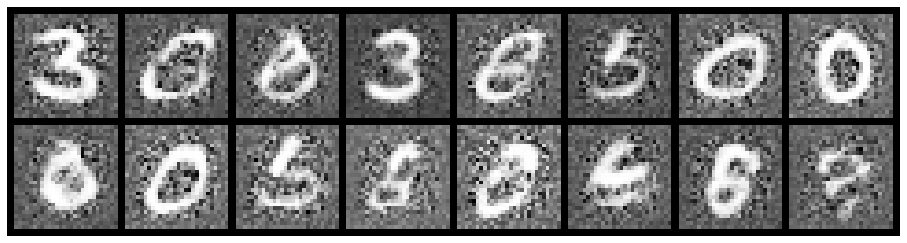

Epoch: [195/200], Batch Num: [0/100]
Discriminator Loss: 0.3241, Generator Loss: 3.5047
D(x): 0.9006, D(G(z)): 0.1010


In [18]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Train Discriminator        
        real_data = data.view(batch_size, -1).to(device=device)  # data size is batch_sizex1x28x28. Since we have batch_size images in each batch having 1 channel each.
        
        fake_data = generator(create_noise(batch_size)).detach()
        fake_data = fake_data.to(device=device)
        
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        
        # Train Generator
        fake_data = generator(create_noise(batch_size))
        
        g_error = train_generator(g_optimizer, fake_data)
        
        logger.log(d_error, g_error, epoch, batch_idx, batch_size)
        
        if epoch % 5 == 0 and batch_idx == 0:
            test_vectors = generator(test_noise)
            test_images = test_vectors.view(test_vectors.size(0), 1, 28, 28).cpu()
            
            logger.log_images(
                test_images, num_test_samples, 
                epoch, batch_idx, batch_size
            );
            
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, batch_idx, batch_size,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        
    


## Saving the models

In [19]:
import pickle
pickle.dump(discriminator, open('discriminator.pkl', 'wb'))
pickle.dump(generator, open('generator.pkl', 'wb'))